## Визуализация промежуточных пространств, анализ «качества пространств»

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models
from tqdm import tqdm
import os
import torchvision

In [2]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = datasets.ImageFolder(
          root='/home/kira/DL_CMC/food-101/images',
          transform=transformations)

In [7]:
n = len(dataset)  
n_test = int(0.2 * n) 
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n - n_test, n_test])

In [8]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=8,
            shuffle=True, 
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=8,
            shuffle=True, 
            num_workers=4)

In [217]:
model = models.vgg16(pretrained=True)
print(model.classifier[6])
num_ftrs = model.classifier[6].in_features

model.classifier[6] = nn.Linear(num_ftrs, 101)
print(model.classifier)

Linear(in_features=4096, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=101, bias=True)
)


## Обучение VGG-16 с помощью transfer learning

In [218]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    model.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [52]:
device

device(type='cuda', index=0)

In [219]:
model.load_state_dict(torch.load('/home/kira/DL_CMC/VGG16.pth'))


<All keys matched successfully>

In [54]:
model.eval() # <3>
running_loss = 0.0
running_corrects = 0


for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()/inputs.size(0)
    running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

epoch_loss = running_loss / len(val_loader)
epoch_acc = running_corrects.double() / len(val_loader)

print(" Val: Loss: {:.4f}"
      " Acc: {:.4f}".format(epoch_loss,
                         epoch_acc))

 Val: Loss: 0.1567 Acc: 0.6708


In [11]:
print(" Val: Loss: {:.4f}"
      " Acc: {:.4f}".format(epoch_loss,
                         epoch_acc))

 Val: Loss: 0.0273 Acc: 0.9457


In [ ]:
num_epochs=25

model.to(device)
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))
    
    model.cpu()
    ckpt_model_filename = "vgg_ckpt_epoch_" + str(epoch) + ".pth"
    ckpt_model_path = os.path.join('/home/kira/DL_CMC', ckpt_model_filename)
    torch.save(model.state_dict(), ckpt_model_path)
    model.to(device)

In [56]:
torch.save(model.state_dict(), '/home/kira/DL_CMC/VGG16_3.pth')

## Изучение признаковых пространств за счет deconv

In [18]:
import cv2

After 2 epoches
layer...4


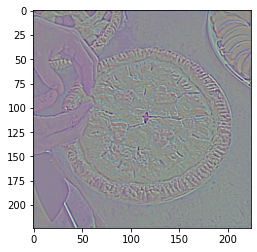

layer...9


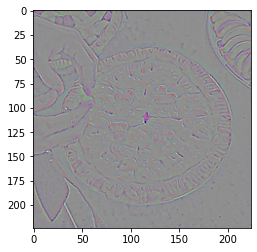

layer...16


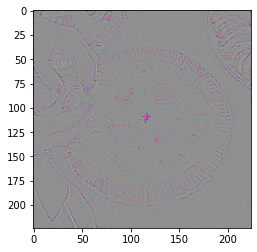

layer...23


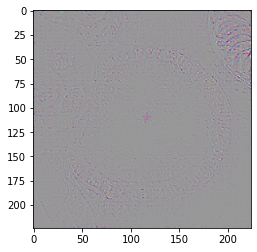

layer...30


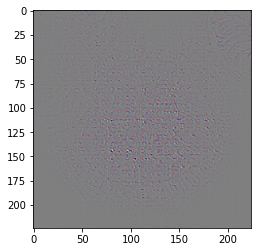

In [220]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list


def filter_feature_maps(raw_feature_maps):
    feature_maps = raw_feature_maps[0]
    feature_maps_total_num = feature_maps.shape[0]

    activation_list = []
    for i in range(feature_maps_total_num):
        activation_val = torch.max(feature_maps[i, :, :])
        activation_list.append(activation_val.item())

    max_map_num = np.argmax(np.array(activation_list))
    max_map = feature_maps[max_map_num, :, :]
    max_activation_val = torch.max(max_map)
    max_map = torch.where(max_map == max_activation_val,
                          max_map,
                          torch.zeros(max_map.shape)
                          )

    for i in range(feature_maps_total_num):
        if i != max_map_num:
            feature_maps[i, :, :] = 0
        else:
            feature_maps[i, :, :] = max_map

    return feature_maps.unsqueeze_(0)


def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y


def visualize(layer_max_count, img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    path = "./output/" + str(layer_max_count) + "th-layer.png"

    plt.imshow(npimg)
    plt.show()
#     plt.imsave(path, npimg)


# raw_img = cv2.imread("/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg")
# raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# resized_img = cv2.resize(raw_img, (224, 224))
raw_img = Image.open(r"/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg") 
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 2 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

After 3 epoches
layer...4


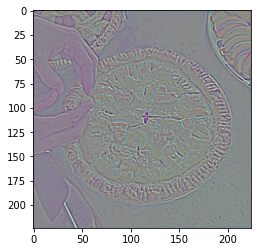

layer...9


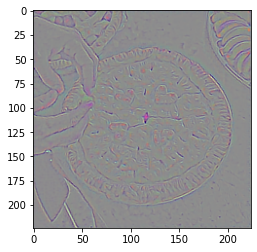

layer...16


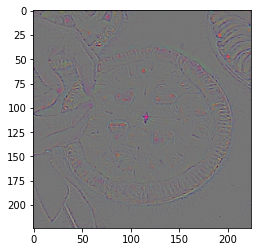

layer...23


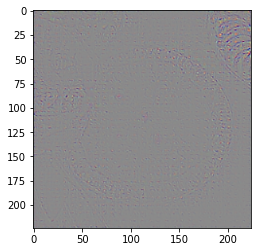

layer...30


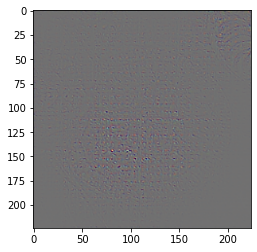

In [230]:
input_img = transformations(raw_img).unsqueeze_(0)
model.load_state_dict(torch.load('/home/kira/DL_CMC/VGG16_3.pth'))

model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 3 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

Попробуем визуализировать картинки, на которых сеть наиболее сильно активировалась

In [222]:
max_activated_images = [{}, {}, {}, {}, {}]

for i in tqdm(range(1000)):
    input_img = dataset[i][0].unsqueeze_(0)
    for j, layer_max_count in enumerate(visualize_layer_indices):
        raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
        
        feature_maps = raw_feature_maps[0]
        feature_maps_total_num = feature_maps.shape[0]

        activation_list = []
        for k in range(feature_maps_total_num):
            activation_val = (feature_maps[k, :, :]).norm()
            activation_list.append(activation_val.item())

        max_map_num = np.argmax(np.array(activation_list))
        if max_map_num not in max_activated_images[j]:
            max_activated_images[j][max_map_num] = [i]
        else:
            max_activated_images[j][max_map_num].append(i)

100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


На чем активируются некоторые отдельные слои четвертого слоя

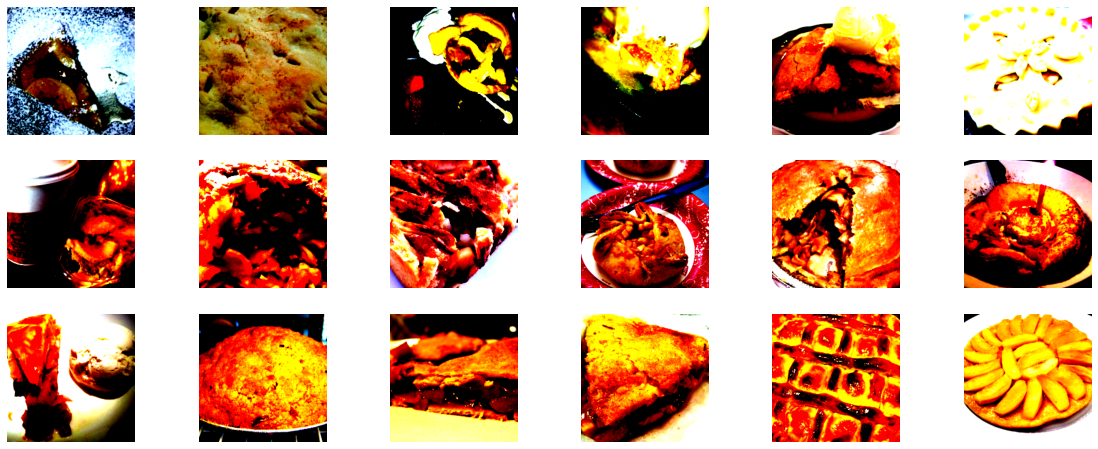

In [229]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[0][41][:6] + max_activated_images[0][19][:6] + max_activated_images[0][20][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Девятого слоя

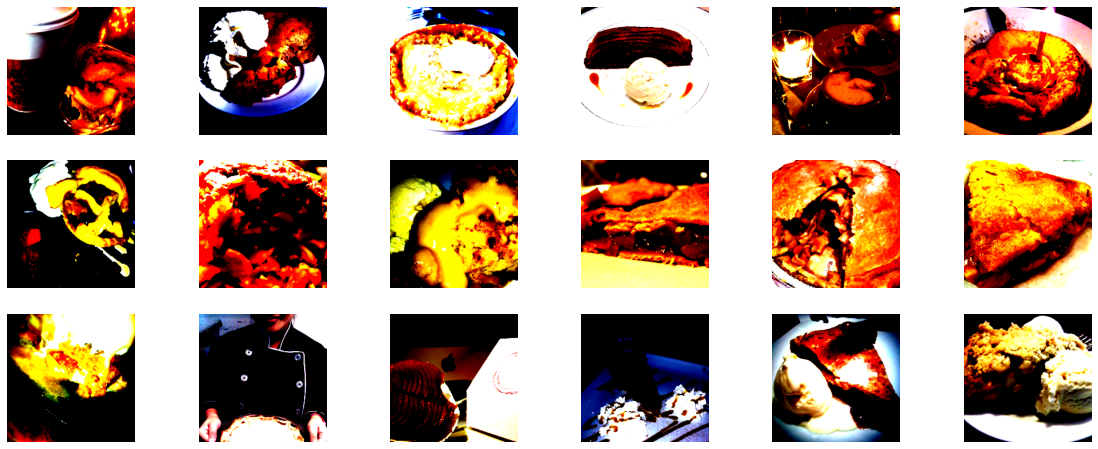

In [232]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[1][43][:6] + max_activated_images[1][72][:6] + max_activated_images[1][63][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Тридцатого слоя

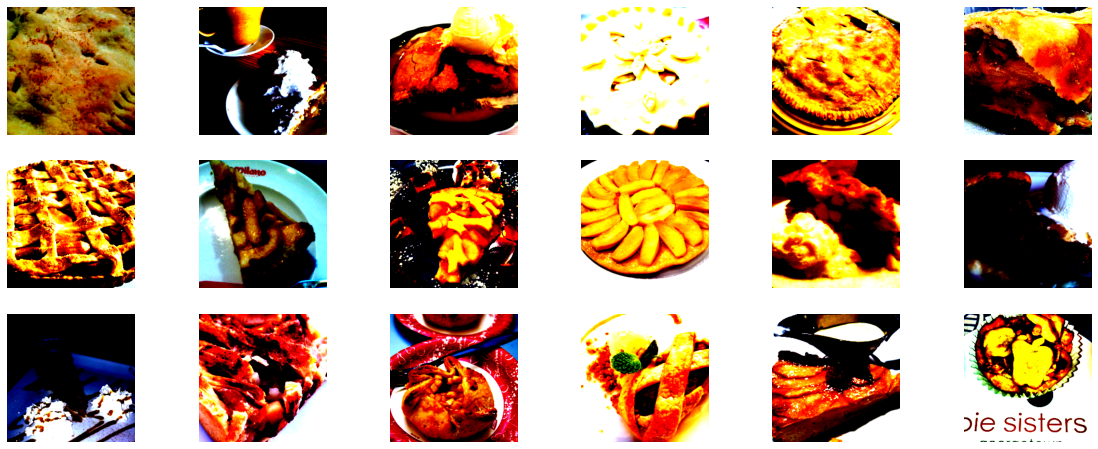

In [234]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[4][307][:6] + max_activated_images[4][77][:6] + max_activated_images[4][26][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Если для более близких слоев к взодному можно найти какую-то закономерность, то для более далеких это становится сложно

После 3ех эпох обучения VGG16 результат все еще не очень хороший. Теперь будем работать с AlexNet

## Обучение AlexNet

In [90]:
model = models.alexnet(pretrained=True)
print(model.classifier[6])
num_ftrs = model.classifier[6].in_features

model.classifier[6] = nn.Linear(num_ftrs, 101)
print(model.classifier)

Linear(in_features=4096, out_features=1000, bias=True)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=101, bias=True)
)


In [75]:
model.load_state_dict(torch.load('/home/kira/DL_CMC/alexnet.pth'))

<All keys matched successfully>

In [91]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    model.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [92]:
device

device(type='cuda', index=0)

In [93]:
num_epochs=1

model.to(device)
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
        if count % 1000 == 0:
            model.cpu()
            ckpt_model_filename = "alexnt" + str(count) + ".pth"
            ckpt_model_path = os.path.join('/home/kira/DL_CMC', ckpt_model_filename)
            torch.save(model.state_dict(), ckpt_model_path)
            model.to(device)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))
    
    model.cpu()
#     ckpt_model_filename = "alexnet_ckpt_epoch_" + str(epoch) + ".pth"
#     ckpt_model_path = os.path.join('/home/kira/DL_CMC', ckpt_model_filename)
#     torch.save(model.state_dict(), ckpt_model_path)
    model.to(device)

100%|██████████| 10100/10100 [02:42<00:00, 62.19it/s]


Train: Loss: 0.3532 Acc: 0.3189 Val: Loss: 0.2941 Acc: 0.4176


In [68]:
torch.save(model.state_dict(), '/home/kira/DL_CMC/alexnet.pth')

layer...2


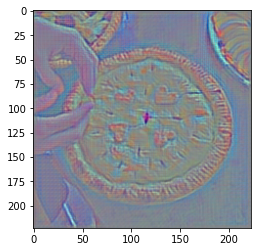

layer...5


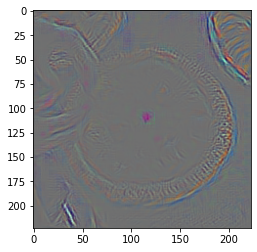

layer...12


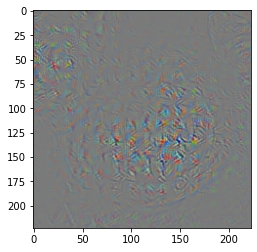

In [72]:
input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

### Как меняется визуализация промежуточных слоев со временем

In [ ]:
def filter_feature_maps(raw_feature_maps):
    feature_maps = raw_feature_maps[0]
    feature_maps_total_num = feature_maps.shape[0]

    activation_list = []
    for i in range(feature_maps_total_num):
        activation_val = (feature_maps[i, :, :]).norm()
        activation_list.append(activation_val.item())

    max_map_num = np.argmax(np.array(activation_list))
    max_map = feature_maps[max_map_num, :, :]
    return feature_maps.unsqueeze_(0)

def visualize(layer_max_count, img, i):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.subplot(3, 10, i + 1)
    plt.axis('off')

    plt.imshow(npimg)

raw_img = Image.open(r"/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg") 
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()



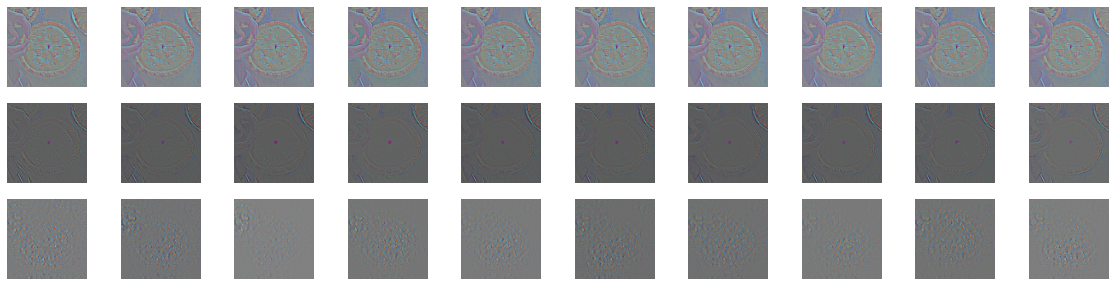

In [112]:
plt.figure(figsize=(20, 5))
model.cpu()

imges = [[], [], []]
for count in range(10):
    model.load_state_dict(torch.load('/home/kira/DL_CMC/alexnt' + str((count + 1) * 1000) + '.pth'))
    for i, layer_max_count in enumerate(visualize_layer_indices):
    #     print("layer...%s" % layer_max_count)
        raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
        filtered_feature_maps = filter_feature_maps(raw_feature_maps)
        reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    #     reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
        imges[i].append(reproducted_img)

        
for i, layer_max_count in enumerate(visualize_layer_indices):
    for count in range(10):
        visualize(layer_max_count, imges[i][count], i * 10 + count)
plt.show()

Видно, что со временем активации почти не меняются. Скорее всего, так происходит из-за того, что у нас уже предобученная модель

Попробуем посмотреть на какие картинки максимально активируется какой слой нейрона

After 2 epoches
layer...2


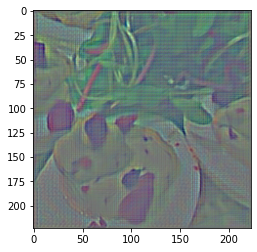

layer...5


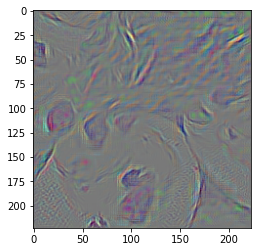

layer...12


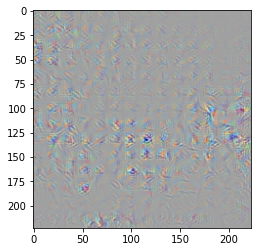

In [142]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list


def filter_feature_maps(raw_feature_maps):
    feature_maps = raw_feature_maps[0]
    feature_maps_total_num = feature_maps.shape[0]

    activation_list = []
    for i in range(feature_maps_total_num):
        activation_val = (feature_maps[i, :, :]).norm()
        activation_list.append(activation_val.item())

    max_map_num = np.argmax(np.array(activation_list))
    max_map = feature_maps[max_map_num, :, :]
    return feature_maps.unsqueeze_(0)


def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y


def visualize(layer_max_count, img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    path = "./output/" + str(layer_max_count) + "th-layer.png"

    plt.imshow(npimg)
    plt.show()

raw_img = Image.open(r"/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg") 
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = dataset[30000][0].unsqueeze_(0)
model.cpu()
model.eval()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 2 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
#     reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

In [138]:
len(dataset)

101000

In [205]:
max_activated_images = [{}, {}, {}]

x = np.zeros(64)
y = np.zeros(192)
z = np.zeros(256)
layers = [x, y, z]
for i in tqdm(range(1000)):
    input_img = dataset[i][0].unsqueeze_(0)
    for j, layer_max_count in enumerate(visualize_layer_indices):
        raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
        
        feature_maps = raw_feature_maps[0]
        feature_maps_total_num = feature_maps.shape[0]

        activation_list = []
        for k in range(feature_maps_total_num):
            activation_val = (feature_maps[k, :, :]).norm()
            activation_list.append(activation_val.item())

        max_map_num = np.argmax(np.array(activation_list))
        layers[j][max_map_num] += 1
        if max_map_num not in max_activated_images[j]:
            max_activated_images[j][max_map_num] = [i]
        else:
            max_activated_images[j][max_map_num].append(i)

100%|██████████| 1000/1000 [00:30<00:00, 32.36it/s]


На чем активируются некоторые отдельные слои первого слоя

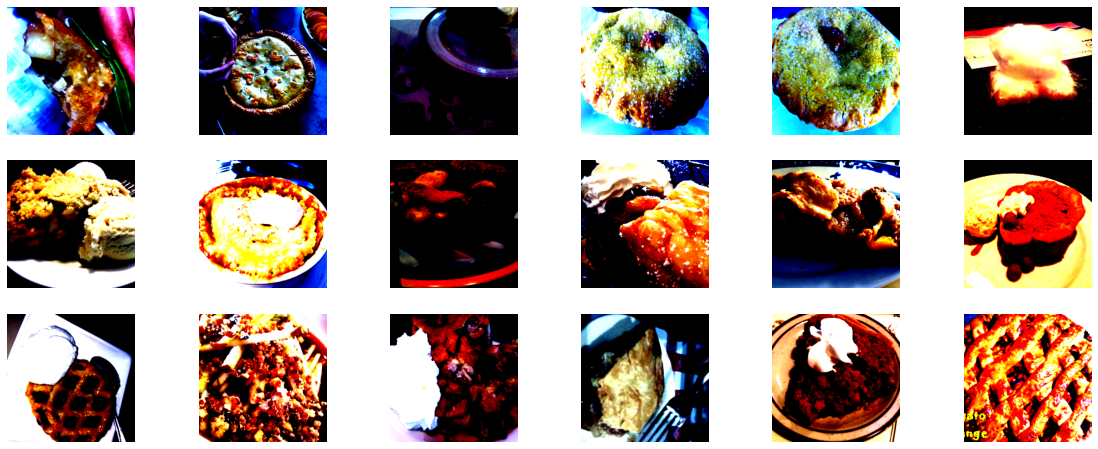

In [208]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[0][35][:6] + max_activated_images[0][59][:6] + max_activated_images[0][5][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Пятого слоя

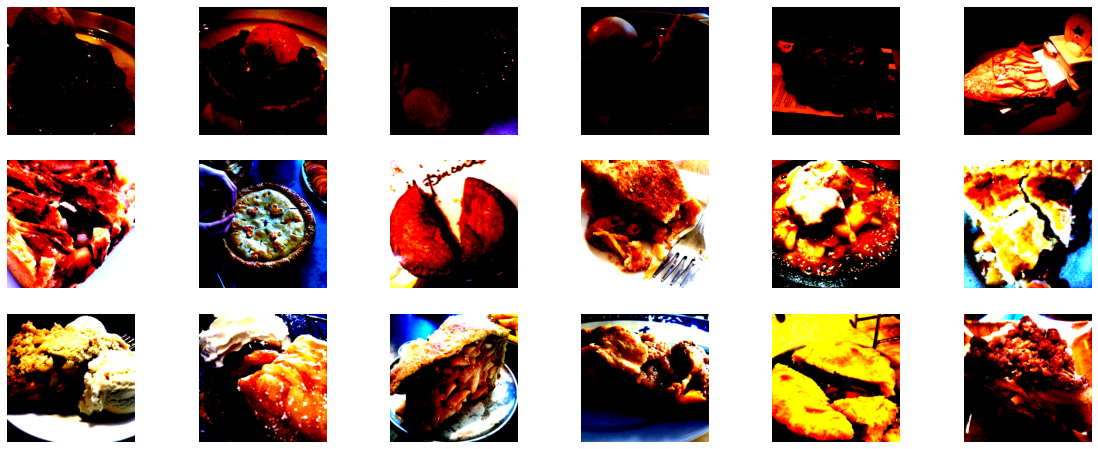

In [213]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[1][115][:6] + max_activated_images[1][184][:6] + max_activated_images[1][158][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Двеннадцатого слоя

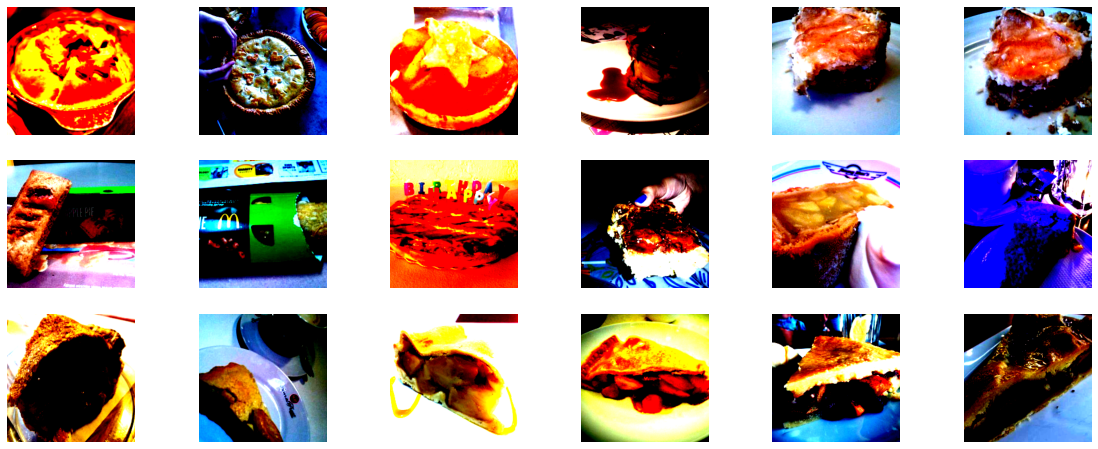

In [216]:
figure = plt.figure(figsize=(20, 8))
for i, num in enumerate(max_activated_images[2][38][:6] + max_activated_images[2][142][:6] + max_activated_images[2][239][:6]):
        figure.add_subplot(3, 6, i + 1)
        plt.axis("off")
        np_img = dataset[num][0].numpy()
        img = np.transpose(np_img, (1,2,0))       
        img = np.clip(img, 0, 1)
        plt.imshow(img)

Интересно, что почти что для всех случаев можно выделить какие-то закономерности, например форма блюда, его яркость, и т.д. Здесь картинки обработаны так, как они подаются на вход сети

## Выводы

Из-за датасета с большим количеством классов и отсутствия безграничной GPU, некоторые модели не смогли хорошо обучиться. Был произведен анализ признаковых пространств, и показано на чем активируются сети VGG16 и AlexNet

Литература:
* https://arxiv.org/pdf/1311.2901.pdf
* https://github.com/r-khanna/Visualizing-and-Understanding-Convolutional-Networks/blob/master/Deconvolution%20implementation.ipynb
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://github.com/okn-yu/Visualizing-and-understanding-convolutional-networks/blob/master/main.py